## GMM-Based Synthetic Sampling for Imbalanced Data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
import numpy as np


### Reading the dataset
---

In [35]:
df = pd.read_csv('creditcard.csv')
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

### Class Distribution

---

Class
0    284315
1       492
Name: count, dtype: int64

Imbalance ratio (Non-Fraud : Fraud) = 577.88 : 1


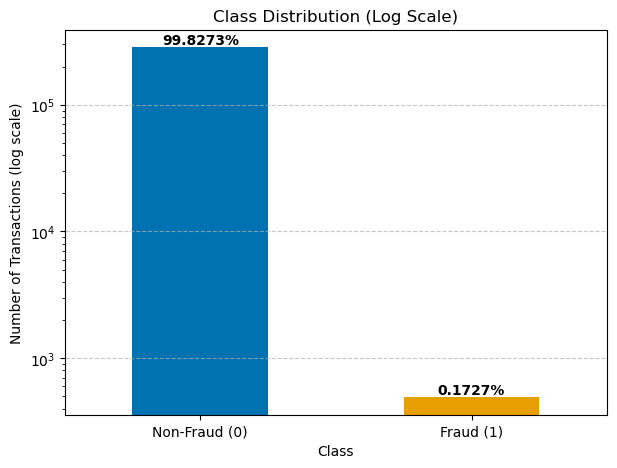

In [36]:
# Class Distribution
class_counts = df["Class"].value_counts()  # 0 = Non-fraud, 1 = Fraud
print(class_counts)

# Degree of imbalance
imbalance_ratio = class_counts[0] / class_counts[1]
print(f"\nImbalance ratio (Non-Fraud : Fraud) = {imbalance_ratio:.2f} : 1")

# Plot
plt.figure(figsize=(7,5))
ax = class_counts.plot(kind="bar", color=["#0072B2", "#E69F00"])
plt.yscale("log")  # log scale
plt.xticks([0,1], ["Non-Fraud (0)", "Fraud (1)"], rotation=0)
plt.ylabel("Number of Transactions (log scale)")
plt.title("Class Distribution (Log Scale)")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Add percentage annotations
total = class_counts.sum()
for i, count in enumerate(class_counts):
    pct = 100 * count / total
    ax.text(i, count, f"{pct:.4f}%", 
            ha="center", va="bottom", fontsize=10, fontweight="bold")

plt.show()

The imbalance ratio tells us the rare occurrence of a fraud. For every 578 normal transations there is a fradulent transaction.

### Splitting dataset
---

In [37]:

# Features and labels
X = df.drop("Class", axis=1)
y = df["Class"]

print(X.columns)

# Split dataset (stratify keeps same imbalance ratio in train/test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

def imbalance_ratio(y):
    counts = y.value_counts()
    return counts[0] / counts[1]

# Print imbalance ratios
train_ratio = imbalance_ratio(y_train)
test_ratio = imbalance_ratio(y_test)

print(f"Training set imbalance ratio (Non-Fraud : Fraud) = {train_ratio:.2f} : 1")
print(f"Testing set imbalance ratio (Non-Fraud : Fraud)  = {test_ratio:.2f} : 1")


Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')
Training set imbalance ratio (Non-Fraud : Fraud) = 578.55 : 1
Testing set imbalance ratio (Non-Fraud : Fraud)  = 576.32 : 1


### Training Baseline Model
---

In [38]:

# Dictionary to store results
results = {"Class": [], "Precision": [], "Recall": [], "F1-Score": [], "Accuracy": []}

model = LogisticRegression(max_iter=10000, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Precision, Recall, F1 for each class (0 and 1)
precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_pred, average=None, labels=[0, 1]
)

# Accuracy is global (same for all classes)
acc = accuracy_score(y_test, y_pred)

for cls, p, r, f in zip([0, 1], precision, recall, f1):
    results["Class"].append(cls)
    results["Precision"].append(p)
    results["Recall"].append(r)
    results["F1-Score"].append(f)
    results["Accuracy"].append(acc)  # same value for both

results_df = pd.DataFrame(results)
print(results_df)

   Class  Precision    Recall  F1-Score  Accuracy
0      0   0.999344  0.999801  0.999572  0.999146
1      1   0.844037  0.621622  0.715953  0.999146


### Evaluation

- **Precision (Fraud = 0.8440):**  
  When the model predicts "fraud," it is correct ~84% of the time. This shows relatively few false alarms.

- **Recall (Fraud = 0.6216):**  
  The model detects ~62% of actual frauds. This means **over one-third of fraudulent transactions are missed**, which is not good.

- **F1-Score (Fraud = 0.7159):**  
  Balances precision and recall. Since both metrics are important, F1 provides a single measure of the model’s effectiveness.

### Why Accuracy is Misleading

- The dataset is **highly imbalanced**: ~99.8% Non-Fraud vs. ~0.2% Fraud.  
- A naive model that **predicts only "Non-Fraud(0)"** would still achieve ~99.8% accuracy, but **detects zero fraud cases**.  
- Thus, accuracy hides poor fraud detection ability.  
- For imbalanced classification, **Recall, Precision, and F1-score for the minority class (Fraud)** are **much better indicators of real performance**.

---




### Theoretical foundation of GMM's

**GMM-based synthetic sampling vs SMOTE**

- **SMOTE (Synthetic Minority Over-sampling Technique)** creates synthetic minority samples by interpolating between a minority sample and one of its nearest minority neighbors. This is simple and effective for many problems but assumes the minority class distribution is locally smooth and that linear interpolation between neighbors produces realistic samples.
- **GMM-based sampling** fits a probabilistic generative model (a mixture of Gaussians) to the minority-class feature distribution. Synthetic samples are drawn from the fitted mixture components according to their mixture weights.

**Why GMM can be better**
- **Multi-modality:** If the minority class contains several sub-groups (modes) or clusters in feature space, a GMM models each mode explicitly (each component can capture a mode), while SMOTE’s interpolations can mix across modes and produce unrealistic samples.
- **Complex shapes:** GMM can approximate complicated continuous distributions by combining components with different means and covariances. This can preserve cluster-specific covariance structure (shape and orientation).
- **Probabilistic sampling:** GMM sampling respects the learned covariance of components (variation directions), producing samples that are more faithful to the minority distribution rather than simply linear blends between neighbors.
- **Noise handling:** Using likelihoods (AIC/BIC) you can select model complexity and identify if the minority distribution is better described by several components or a single one.

**Limitations**
- GMM assumes approximately Gaussian components — if modes are strongly non-Gaussian, other generative methods may be better.
- Requires careful selection of the number of components and regularization to avoid overfitting.

---




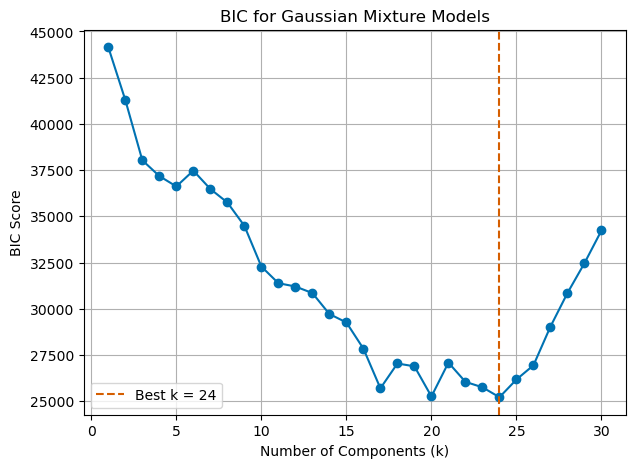

Best k by BIC: 24


In [39]:
# Extract majority and minority samples
X_minority = X_train[y_train == 1]
X_majority = X_train[y_train == 0]


# Fit GMM with different components and compute BIC
results = []
models = {}
for k in range(1, 31):
    gmm = GaussianMixture(
        n_components=k,
        covariance_type='full',
        random_state=42,
        reg_covar=1e-6
    )
    gmm.fit(X_minority)
    results.append((k, gmm.bic(X_minority)))
    models[k] = gmm

# Put results in DataFrame
results_df = pd.DataFrame(results, columns=["k", "BIC"]).set_index("k")

# Choose best model (lowest BIC)
best_k = results_df["BIC"].idxmin()
best_gmm = models[best_k]

# Plot BIC vs k
plt.figure(figsize=(7,5))
plt.plot(np.arange(1,31), np.array(results_df["BIC"]), marker="o", color='#0072B2')
plt.xlabel("Number of Components (k)")
plt.ylabel("BIC Score")
plt.title("BIC for Gaussian Mixture Models")
plt.axvline(best_k, color="#D55E00", linestyle="--", label=f"Best k = {best_k}")
plt.legend()
plt.grid()
plt.show()

print(f"Best k by BIC: {best_k}")


### Bayesian Information Criterion (BIC)

The **Bayesian Information Criterion (BIC)** is a statistical measure used for **model selection**.  
It evaluates how well a model fits the data while applying a penalty for model complexity (number of parameters).  

The formula is:

$
\text{BIC} = -2 \cdot \ln(L) + p \cdot \ln(N)
$

where:
- \(L\) = maximum likelihood of the model  
- \(p\) = number of free parameters in the model  
- \(N\) = number of data points  

---

#### Interpretation
- **Lower BIC = better model.**  
- BIC penalizes models with too many parameters, preventing overfitting.  
- BIC applies a **stronger penalty** for complexity, so it tends to prefer simpler models unless added complexity significantly improves fit.  


#### In Gaussian Mixture Models (GMM):
- Each choice of number of components \(k\) gives a different BIC value.  
- The **optimal number of components** is the one with the **lowest BIC**.  
- This represents the best trade-off between **fit** (capturing the minority class distribution) and **number of clusters** (avoiding unnecessary Gaussian clusters).

---

### Fitting a Gaussian Mixture Model

---

In [40]:

def GMM(scale = 1):
    #Generate synthetic samples
    n_minority = len(X_train[y_train == 1])
    n_majority = len(X_train[y_train == 0])

    n_to_generate = scale*(n_majority - n_minority)   # balance fraud to non-fraud

    # Generate synthetic frauds
    X_synthetic, _ = best_gmm.sample(n_to_generate)


    # Augmented minority dataset
    X_min_aug = np.vstack([X_minority, X_synthetic])
    y_min_aug = np.ones(len(X_min_aug))

    # Majority dataset
    X_majority = X_train[y_train == 0]
    y_majority = np.zeros(len(X_majority))

    # Final balanced dataset
    X_train_gmm = np.vstack([X_majority, X_min_aug])
    y_train_gmm = np.hstack([y_majority, y_min_aug])

    print("----------------------------------------------")
    print('Sythetic sample generation via GMMs')
    print("----------------------------------------------")
    print(f"Generated {len(X_synthetic)} synthetic fraud samples.")
    print("Ratio of normal to frad samples:", 
          round(len(X_train_gmm[y_train_gmm==1])/len(X_train_gmm[y_train_gmm==0]),2))
    print()

    return X_train_gmm, y_train_gmm

X_train_gmm, y_train_gmm = GMM(scale = 0.04)    


----------------------------------------------
Sythetic sample generation via GMMs
----------------------------------------------
Generated 7947 synthetic fraud samples.
Ratio of normal to frad samples: 0.04



### Sampling from a Fitted GMM

When sampling from a fitted GMM:

1. The model has **mixture weights** (π₁, π₂, …, πₖ) for each Gaussian component.  
   - Example (for k=5): π = [0.25, 0.20, 0.15, 0.30, 0.10].

2. To generate one synthetic point, the algorithm **randomly selects a component index `k`**.  
   - The probability of picking component `i` is equal to its weight πᵢ.  
   - In the example above:
     - Component 1 is picked ~25% of the time.  
     - Component 4 is picked ~30% of the time.  
     - Component 5 is picked only ~10% of the time.

3. From that chosen Gaussian (with mean μ_k and covariance Σ_k), a random point is drawn 
   - This is just sampling from a multivariate normal distribution. 

4. Repeating this process many times gives a synthetic dataset where the proportion of points from each component **matches the learned mixture weights**.

---

### Elbow Method to find no. of clusters

---

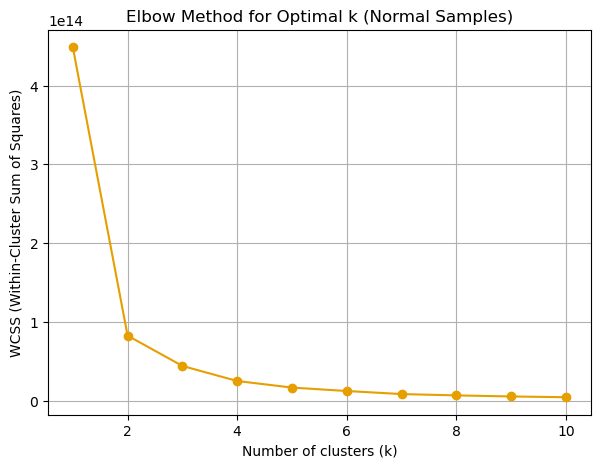

In [41]:
wcss_majority = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_majority)  # only fraud samples
    wcss_majority.append(kmeans.inertia_)  # inertia_ = WCSS

plt.figure(figsize=(7,5))
plt.plot(K, wcss_majority, marker='o',color='#E69F00')
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal k (Normal Samples)")
plt.grid()
plt.show()

We can observe for the Normal (Non fraud [0] class) k = 2 is a good choice.

### Rebalancing using Cluster based Undersampling + GMM's
---

In [42]:
def Rebalance_CBU(scale=1.0, n_clusters=2, random_state=42):

    # Split minority & majority
    X_minority = X_train[y_train == 1]
    X_majority = X_train[y_train == 0]

    n_minority = len(X_minority)
    n_majority = len(X_majority)

    # Undersample majority with clustering ---
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    labels = kmeans.fit_predict(X_majority)

    # keep equal number from each cluster, proportional to cluster size
    target_majority = int(scale * n_majority)  # can tune scale here
    sampled_indices = []

    for cid in np.unique(labels):
        idx = np.where(labels == cid)[0]
        n_select = max(1, int(len(idx) * target_majority / n_majority))
        chosen = np.random.choice(idx, size=n_select, replace=False)
        sampled_indices.extend(chosen)

    X_majority_reduced = X_majority.iloc[sampled_indices]
    y_majority_reduced = np.zeros(len(X_majority_reduced))

    # Oversample minority with GMM 
    n_to_generate = len(X_majority_reduced) - n_minority
    if n_to_generate > 0:
        X_synthetic, _ = best_gmm.sample(n_to_generate)
        X_min_aug = np.vstack([X_minority, X_synthetic])
    else:
        X_min_aug = X_minority.copy()

    y_min_aug = np.ones(len(X_min_aug))

    # Combine 
    X_bal = np.vstack([X_majority_reduced, X_min_aug])
    y_bal = np.hstack([y_majority_reduced, y_min_aug])

    print("----------------------------------------------")
    print("Downsampling using CBU + upsampling via GMM for class balance")
    print("----------------------------------------------")
    print('Downsampling scale = ',scale)
    print(f"Final counts: Majority: {len(y_majority_reduced)}, Minority: {len(y_min_aug)}")
    print("Ratio minority/majority:", round(len(y_min_aug) / len(y_majority_reduced), 2))
    print()

    return X_bal, y_bal

# Example usage
X_train_CBU_GMM, y_train_CBU_GMM = Rebalance_CBU(scale=0.1, n_clusters=2)


----------------------------------------------
Downsampling using CBU + upsampling via GMM for class balance
----------------------------------------------
Downsampling scale =  0.1
Final counts: Majority: 19901, Minority: 19901
Ratio minority/majority: 1.0



### Training various models

---

In [48]:
# Dictionary to store training sets

X_train_gmm, y_train_gmm = GMM(scale=0.004)
X_train_gmm_full, y_train_gmm_full = GMM(scale=1.0)
X_train_cbu_gmm, y_train_cbu_gmm = Rebalance_CBU(scale= 0.01, n_clusters=2)
X_train_cbu_gmm_high, y_train_cbu_gmm_high = Rebalance_CBU(scale= 0.5, n_clusters=2)

train_sets = {
    "Baseline": (X_train, y_train),
    "GMM \n(ratio= 0.004)": (X_train_gmm, y_train_gmm),
    "GMM \n(ratio= 1.0)": (X_train_gmm_full, y_train_gmm_full),
    "GMM + CBU \n(scale= 0.01) ": (X_train_cbu_gmm, y_train_cbu_gmm),
    "GMM + CBU \n(scale= 0.5) ": (X_train_cbu_gmm_high, y_train_cbu_gmm_high)
}

# Dictionaries to store results
results_minority = {"Model": [], "Precision": [], "Recall": [], "F1-Score": [], "Accuracy": []}
results_majority = {"Model": [], "Precision": [], "Recall": [], "F1-Score": [], "Accuracy": []}

for name, (X_tr, y_tr) in train_sets.items():
    # Convert to numpy
    X_tr = np.asarray(X_tr)
    y_tr = np.asarray(y_tr)
    X_te = np.asarray(X_test)
    y_te = np.asarray(y_test)

    # Train model
    model = LogisticRegression(max_iter=10000, random_state=42)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    # Full classification report as dictionary
    report = classification_report(y_te, y_pred, output_dict=True, zero_division=0)

    # Extract metrics
    acc = report["accuracy"]

    # Minority class (fraud = 1)
    results_minority["Model"].append(name)
    results_minority["Precision"].append(report["1"]["precision"])
    results_minority["Recall"].append(report["1"]["recall"])
    results_minority["F1-Score"].append(report["1"]["f1-score"])
    results_minority["Accuracy"].append(acc)

    # Majority class (no fraud = 0)
    results_majority["Model"].append(name)
    results_majority["Precision"].append(report["0"]["precision"])
    results_majority["Recall"].append(report["0"]["recall"])
    results_majority["F1-Score"].append(report["0"]["f1-score"])
    results_majority["Accuracy"].append(acc)




----------------------------------------------
Sythetic sample generation via GMMs
----------------------------------------------
Generated 794 synthetic fraud samples.
Ratio of normal to frad samples: 0.01

----------------------------------------------
Sythetic sample generation via GMMs
----------------------------------------------
Generated 198676 synthetic fraud samples.
Ratio of normal to frad samples: 1.0

----------------------------------------------
Downsampling using CBU + upsampling via GMM for class balance
----------------------------------------------
Downsampling scale =  0.01
Final counts: Majority: 1989, Minority: 1989
Ratio minority/majority: 1.0

----------------------------------------------
Downsampling using CBU + upsampling via GMM for class balance
----------------------------------------------
Downsampling scale =  0.5
Final counts: Majority: 99509, Minority: 99509
Ratio minority/majority: 1.0



Minority class (fraud = 1) results:
                         Model  Precision    Recall  F1-Score  Accuracy
0                    Baseline   0.844037  0.621622  0.715953  0.999146
1        GMM \n(ratio= 0.004)   0.801418  0.763514  0.782007  0.999263
2          GMM \n(ratio= 1.0)   0.083553  0.858108  0.152278  0.983451
3  GMM + CBU \n(scale= 0.01)    0.066597  0.864865  0.123671  0.978769
4   GMM + CBU \n(scale= 0.5)    0.084225  0.851351  0.153285  0.983708

Majority class (no fraud = 0) results:
                         Model  Precision    Recall  F1-Score  Accuracy
0                    Baseline   0.999344  0.999801  0.999572  0.999146
1        GMM \n(ratio= 0.004)   0.999590  0.999672  0.999631  0.999263
2          GMM \n(ratio= 1.0)   0.999750  0.983668  0.991644  0.983451
3  GMM + CBU \n(scale= 0.01)    0.999761  0.978967  0.989255  0.978769
4   GMM + CBU \n(scale= 0.5)    0.999738  0.983938  0.991775  0.983708


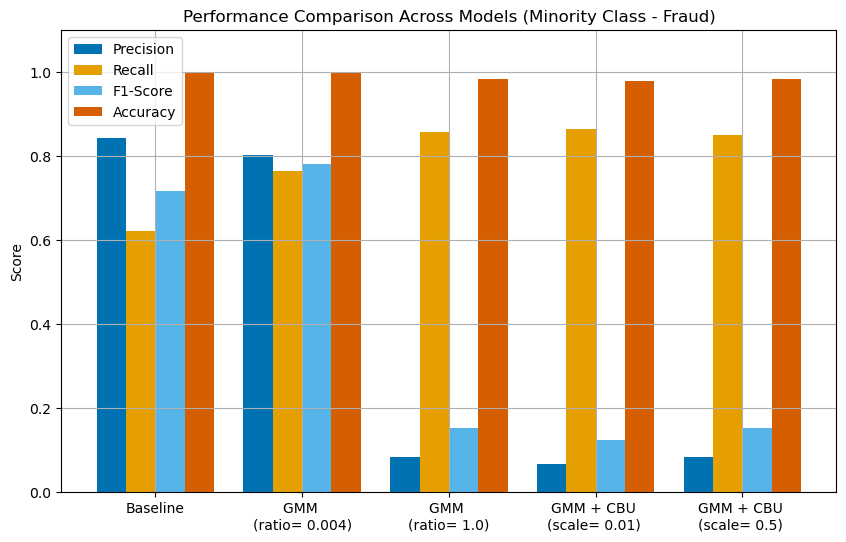

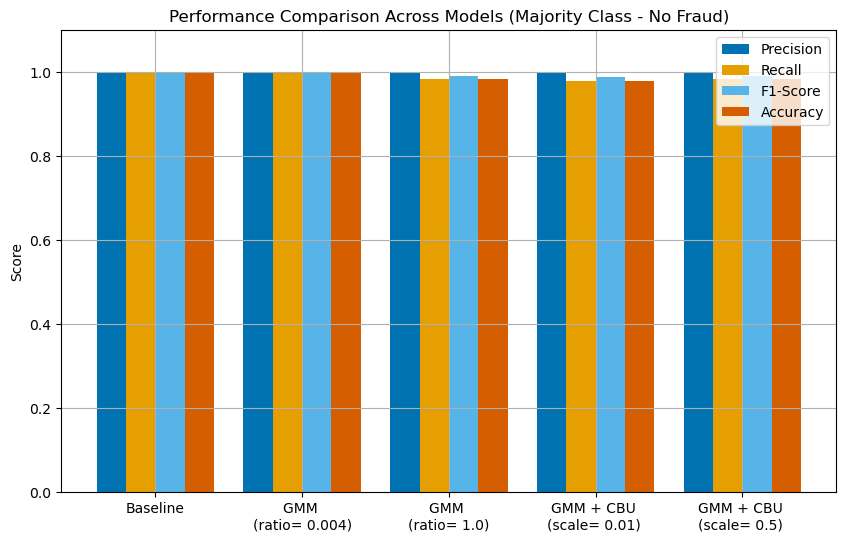

In [49]:

# Convert to DataFrames
results_minority_df = pd.DataFrame(results_minority)
results_majority_df = pd.DataFrame(results_majority)

print("Minority class (fraud = 1) results:\n", results_minority_df)
print("\nMajority class (no fraud = 0) results:\n", results_majority_df)

# Minority class plot
fig, ax = plt.subplots(figsize=(10,6))
width = 0.2
x = range(len(results_minority_df))

ax.bar([i - 1.5*width for i in x], results_minority_df["Precision"], width=width, label="Precision", color="#0072B2")  # Blue
ax.bar([i - 0.5*width for i in x], results_minority_df["Recall"], width=width, label="Recall", color="#E69F00")       # Orange
ax.bar([i + 0.5*width for i in x], results_minority_df["F1-Score"], width=width, label="F1-Score", color="#56B4E9")  # Sky Blue
ax.bar([i + 1.5*width for i in x], results_minority_df["Accuracy"], width=width, label="Accuracy", color="#D55E00")  # Vermillion

ax.set_xticks(x)
ax.set_xticklabels(results_minority_df["Model"])
ax.set_ylabel("Score")
ax.set_title("Performance Comparison Across Models (Minority Class - Fraud)")
ax.legend()
plt.ylim(0,1.1)
plt.grid()
plt.show()

# Majority class plot
fig, ax = plt.subplots(figsize=(10,6))
x = range(len(results_majority_df))

ax.bar([i - 1.5*width for i in x], results_majority_df["Precision"], width=width, label="Precision", color="#0072B2")  
ax.bar([i - 0.5*width for i in x], results_majority_df["Recall"], width=width, label="Recall", color="#E69F00")       
ax.bar([i + 0.5*width for i in x], results_majority_df["F1-Score"], width=width, label="F1-Score", color="#56B4E9")  
ax.bar([i + 1.5*width for i in x], results_majority_df["Accuracy"], width=width, label="Accuracy", color="#D55E00")  

ax.set_xticks(x)
ax.set_xticklabels(results_majority_df["Model"])
ax.set_ylabel("Score")
ax.set_title("Performance Comparison Across Models (Majority Class - No Fraud)")
ax.legend()
plt.ylim(0,1.1)
plt.grid()
plt.show()



### Results (Minority class)

| Model                    | Precision | Recall | F1-Score | Accuracy |
| ------------------------ | --------- | ------ | -------- | -------- |
| Baseline                 | 0.8440    | 0.6216 | 0.7160   | 0.9991   |
| GMM (ratio = 0.004)      | 0.8014    | 0.7635 | 0.7820   | 0.9993   |
| GMM (ratio = 1.0)        | 0.0836    | 0.8581 | 0.1523   | 0.9835   |
| GMM + CBU (scale = 0.01) | 0.0800    | 0.8581 | 0.1463   | 0.9827   |
| GMM + CBU (scale = 0.5)  | 0.0831    | 0.8514 | 0.1514   | 0.9835   |

### Results (Majority class)
| Model                        | Precision | Recall   | F1-Score | Accuracy |
|------------------------------|-----------|----------|----------|----------|
| Baseline                     | 0.999344  | 0.999801 | 0.999572 | 0.999146 |
| GMM \n(ratio= 0.004)         | 0.999590  | 0.999672 | 0.999631 | 0.999263 |
| GMM \n(ratio= 1.0)           | 0.999750  | 0.983668 | 0.991644 | 0.983451 |
| GMM + CBU \n(scale= 0.01)    | 0.999761  | 0.978967 | 0.989255 | 0.978769 |
| GMM + CBU \n(scale= 0.5)     | 0.999738  | 0.983938 | 0.991775 | 0.983708 |


### Explanation of Parameters  

- **Ratio (in GMM sampling):**  
  - Refers to the **minority-to-majority sample ratio** after synthetic generation.  
  - Example: `ratio = 0.004` means that after GMM-based oversampling, the number of fraud (minority) samples is about **0.4% of the majority class size**.  
  - `ratio = 1.0` means **equal number of minority and majority samples** (perfectly balanced dataset via oversampling).  

- **Scale (in GMM + CBU):**  
  - Refers to the **downsampling factor applied to the majority class** during **Clustering-Based Undersampling (CBU)**.  
  - The number of majority samples kept = `scale × original majority size`.  
  - Example:  
    - `scale = 0.01` → keep only **1% of majority samples**, then balance with GMM-based minority oversampling.  
    - `scale = 0.5` → keep **50% of majority samples**, then oversample minority accordingly.  


### Impact of GMM-based Oversampling on Classifier Performance  (Minority Class) 

1. **Baseline (no resampling):**  
   - Precision = **0.84**, Recall = **0.62**, F1 = **0.72**  
   - The model is quite conservative: when it predicts fraud, it is often correct, but it misses ~38% of actual fraud cases.  

2. **GMM (ratio = 0.004):**  
   - Precision = **0.80**, Recall = **0.76**, F1 = **0.78**  
   - Compared to baseline, **recall increased** (better fraud detection), while precision dropped slightly.  
   - This is a desirable trade-off: more fraud cases are being caught, with only a small increase in false alarms.  

3. **GMM (ratio = 1.0):**  
   - Precision = **0.08**, Recall = **0.86**, F1 = **0.15**  
   - Recall skyrockets, meaning almost all fraud is detected, but precision collapses.  
   - The classifier is flagging too many legitimate transactions as fraud → **impractical in real-world banking applications**.  

4. **GMM + CBU (scale = 0.01 or 0.5):**  
   - Similar to GMM (ratio = 1.0): recall remains high (~0.85), precision very low (~0.08).  
   - CBU helped reduce dataset imbalance, but the extreme oversampling still causes overfitting to synthetic fraud samples, harming precision.  

---

### Did GMM Improve Minority Class Detection?  

- **Yes, partially.**  
  - At moderate ratios (e.g., **0.004**), GMM-based oversampling **improves recall while maintaining a reasonable precision**, leading to a better F1 score than baseline.  
  - At extreme ratios (e.g., **1.0**), GMM forces the dataset to be balanced, but this causes the classifier to **over-predict fraud**, inflating recall at the cost of near-useless precision.  

---

### Recommendation  

- **Effective use of GMM:**  
  - GMM-based oversampling is **effective when used conservatively** (small ratios).  
  - It captures the underlying distribution of minority samples better than simpler methods like SMOTE, leading to synthetic fraud examples that improve the model’s sensitivity without overwhelming it.  

- **Not recommended at high ratios:**  
  - Forcing a perfectly balanced dataset (ratio = 1.0) with GMM leads to **severe precision loss**, making the model impractical for fraud detection (too many false positives).  

- **Best practice:**  
  - Use **moderate GMM oversampling (ratio ≈ 0.004–0.01)**, where recall improves meaningfully while precision remains acceptable.  

  - Never force the dataset to be balanced between both classes because that never gives meaningful results. This suggests that the underlying fact that the ratio between fraud and non fraud is very small itself is a significant factor that makes the model perform better. 

### Conclusion  

GMM-based oversampling **can improve fraud detection** by boosting recall, but it must be applied cautiously.  

- At **moderate ratios (≈ 0.004–0.01)**, GMM creates realistic synthetic fraud samples that help the model catch more fraud while keeping precision at an acceptable level.  
- At **high ratios (≈ 1.0)**, forcing a perfectly balanced dataset causes the model to **over-predict fraud**, leading to severe precision loss and too many false positives.  
- Combining GMM with clustering-based undersampling (CBU) can reduce imbalance, but aggressive resampling should be avoided.  
- Using ratio of 0.004 also improved the F1 score on the majority class which again suggests to use GMM but with moderate oversampling.

**Recommendation:**  
For real-world fraud detection, use **moderate GMM oversampling** (not full balancing) to achieve the best trade-off between **high recall** (catching fraud) and **reasonable precision** (avoiding false alarms).

---
